In [1]:
%load_ext autoreload

%autoreload

In [2]:
import sys
!{sys.executable} -m pip install SimpleITK

In [13]:
import json
import sys
import cv2
import json
import h5py
import numpy as np
import SimpleITK as sitk
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

# custom
from utils import blend_images, normalize_pixel_values, convert_to, plot_two_imgs, resize_img, rgb_to_grayscale, select_appropriate_pyramid_level, rescale_img, pad_img, rotate_image
from ants_registration import ants_registration, plot_images

In [22]:
# load two images : one blockface + one transmittance
data = json.load(open('pli_paths.json'))

bf_path = data['blockface']['348']
trans_path = data['transmittance']['348']

bf_path = bf_path.replace("/p/data1/", "/home/zeynepboztoprak/p/data1/")
trans_path = trans_path.replace("/p/data1/", "/home/zeynepboztoprak/p/data1/")

bf_fd = h5py.File(bf_path, 'r')
trans_fd = h5py.File(trans_path, 'r')

In [23]:
pyramid_level = select_appropriate_pyramid_level(trans_path, bf_path)

bf_img = bf_fd['Image'][:]
trans_img = trans_fd['pyramid'][pyramid_level][:]

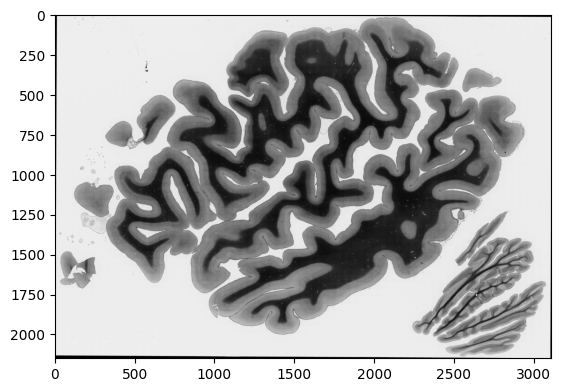

In [24]:
rotated_trans = rotate_image(trans_img, 180)

plt.imshow(rotated_trans, cmap='gray')

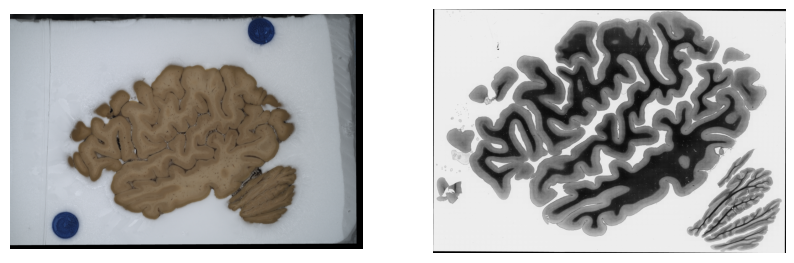

In [26]:
plot_two_imgs(bf_img, rotated_trans)

In [27]:
bf_img.shape, rotated_trans.shape

((3648, 5472, 3), (2150, 3109))

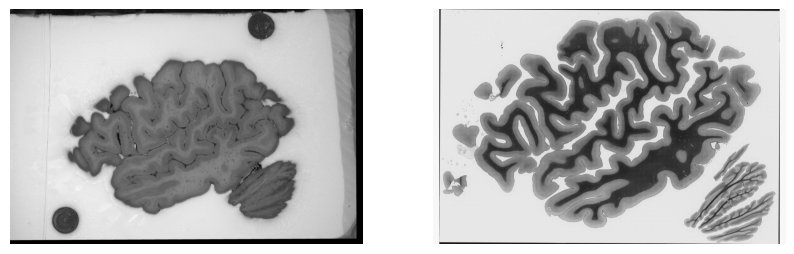

((3648, 5472), (3648, 5472))

In [28]:
bf_img = convert_to(bf_img, np.float32)
rotated_trans = convert_to(rotated_trans, np.float32)

bf_img = normalize_pixel_values(bf_img, max_val=1.)
rotated_trans = normalize_pixel_values(rotated_trans, max_val=1.)

bf_img = rgb_to_grayscale(bf_img)
rotated_trans = rescale_img(rotated_trans, bf_img.shape)

rotated_trans = pad_img(rotated_trans, bf_img.shape, padding_value=1.)

plot_two_imgs(bf_img, rotated_trans)

bf_img.shape, rotated_trans.shape

# SyN: Symmetric normalization: Affine + deformable transformation, with mutual information as optimization metric.

In [29]:
registration = ants_registration(fixed=bf_img, moving=rotated_trans, type_of_transformation='SyN')

registered_image = registration['registered']
registered_inverse_transformed = registration['registered_inv_transformed']
moving_transformed = registration['moving_transformed']

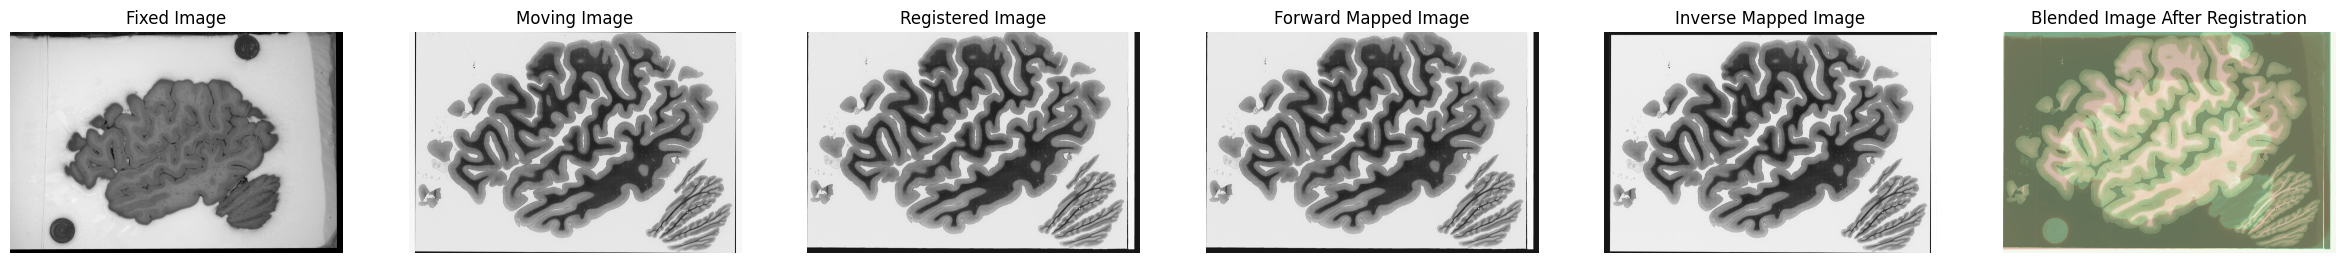

In [30]:
plot_images(bf_img, rotated_trans, registered_image, moving_transformed, registered_inverse_transformed)

In [33]:
import ants

bf_img = ants.from_numpy(bf_img)
rotated_trans = ants.from_numpy(rotated_trans)

# Step 1: Initial Affine Registration
affine_transform = ants.registration(fixed=bf_img, moving=rotated_trans, type_of_transform='Affine')

# Apply the affine transformation to the moving image
affine_transformed_image = ants.apply_transforms(fixed=bf_img, moving=rotated_trans, transformlist=affine_transform['fwdtransforms'])

# Step 2: Non-linear SyN Registration
syn_transform = ants.registration(fixed=bf_img, moving=affine_transformed_image, type_of_transform='SyN')

# Apply the SyN transformation to the affine-transformed image
final_transformed_image = ants.apply_transforms(fixed=bf_img, moving=affine_transformed_image, transformlist=syn_transform['fwdtransforms'])


(-0.5, 5471.5, 3647.5, -0.5)

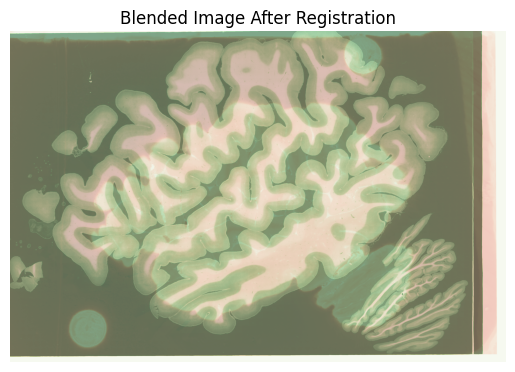

In [36]:
fig, axes = plt.subplots(1, 1)

axes.imshow(bf_img.numpy(), cmap='Reds', alpha=0.5)
axes.imshow(final_transformed_image.numpy(), cmap='Greens', alpha=0.5)
axes.set_title('Blended Image After Registration')
axes.axis('off')

